In [1]:
import os
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
from os.path import join
import scipy.io
from torchvision.datasets.utils import download_url, list_dir, list_files

### hyper parameter setting

In [2]:
h_p = {
    'lr': 2e-4,
    'betas': (0.5, 0.999),
    'z_dim': 100,
    'device': "cuda" if torch.cuda.is_available() else "cpu",
    'epochs': 10,
    'img_size': 64,
    'criterion': nn.BCELoss(),
    'batch_size': 100,
    'img_channel': 1,
    'num_classes': 10,
    'embed_size': 100
}

### Load data to dataloader

In [3]:
dir_name = "FashionMNIST_dataset"
os.makedirs(dir_name , exist_ok=True)
transform = transforms.Compose([
        transforms.Resize((h_p['img_size'], h_p['img_size'])), 
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
dataset = datasets.FashionMNIST(root=dir_name, transform=transform, download=True, train=True)
dataloader = data.DataLoader(dataset=dataset, batch_size=h_p['batch_size'], shuffle=True)

# dir_name = "CIFAR10_dataset"
# os.makedirs(dir_name , exist_ok=True)
# transform = transforms.Compose([
#         transforms.Resize((hyper_param['img_size'], hyper_param['img_size'])), 
#         transforms.ToTensor(), 
#         transforms.Normalize((0.5,), (0.5,))
#     ])
# dataset = datasets.CIFAR10(root=dir_name, transform=transform, download=True, train=True)
# dataloader = data.DataLoader(dataset=dataset, batch_size=h_p['batch_size'], shuffle=True)

### DCGAN model

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, num_classes, img_size, embed_size):
        super().__init__()
        # DCGAN block
        def gen_block(in_channels, out_channels, kernal_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, 
                    out_channels, 
                    kernal_size, 
                    stride, 
                    padding,
                    bias=False
                ),
                # nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        self.img_size = img_size
        self.model = nn.Sequential(
                *gen_block(z_dim+embed_size, 1024, 4, 1, 0), #->4*4
                *gen_block(1024, 512, 4, 2, 1), #->8*8
                *gen_block(512, 256, 4, 2, 1), #->16*16
                *gen_block(256, 128, 4, 2, 1), #->32*32
                nn.ConvTranspose2d(128, img_channels, 4, 2, 1), #->64*64
                nn.Tanh()
            )
        self.embed = nn.Embedding(num_classes, embed_size)
    
    def init_weight(self):
        for m in self.model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def forward(self, x, labels):
        # latent vector z: N x noise_dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes, img_size):
        super().__init__()
        # DCGAN block
        def disc_block(in_channels, out_channels, kernal_size, stride, padding):
            return nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernal_size, 
                    stride, 
                    padding, 
                    bias=False
                ),
                # nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
            )

        self.img_size = img_size
        self.model = nn.Sequential(
                # Input: N * channels * 64 * 64 + 1 for label embed
                nn.Conv2d(img_channels+1, 64, 4, 2, 1), #-> 32*32
                nn.LeakyReLU(0.2),
                *disc_block(64, 128, 4, 2, 1), #-> 16*16
                *disc_block(128, 256, 4, 2, 1), #-> 8*8
                *disc_block(256, 512, 4, 2, 1), #-> 4*4
                nn.Conv2d(512, 1, 4, 2, 0), # 1*1
                nn.Sigmoid(),
            )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1) # N x C x img_size x img_size
        return self.model(x)

### model training

In [5]:
def GAN_training(model):
    progress = tqdm.tqdm(total=h_p['epochs'])
    loss_all = {'G_loss': [], 'D_loss':[]}
    start_time = time.time()
    for epoch in range(1, h_p['epochs']+1):
        for batch_idx, (real_img, label) in enumerate(dataloader):
            real_img = real_img.to(h_p['device'])
            noise = torch.randn((h_p['batch_size'], h_p['z_dim'], 1, 1)).to(h_p['device'])
            label = label.to(h_p['device'])

            # 高斯distribution
            # Train Discriminator: max(E log(D(img)) + E log(1-D(G(z))))
            # G(z)
            fake_img = model['G'](noise, label)
            # D(img), D(G(z))
            D_real_img = model['D'](real_img, label).view(-1)
            D_fake_img = model['D'](fake_img, label).view(-1)
                
            # log(D(img)), log(1-D(G(z)))
            loss_D_real = h_p['criterion'](D_real_img, torch.ones_like(D_real_img))
            loss_D_fake = h_p['criterion'](D_fake_img, torch.zeros_like(D_fake_img))
            loss_D = (loss_D_real + loss_D_fake) / 2
            
            model['D'].zero_grad()
            loss_D.backward(retain_graph=True)
            model['optim_D'].step()

            output = model['D'](fake_img, label).view(-1)
            # Train Generator max(log(D(G(z)))
            loss_G = h_p['criterion'](output, torch.ones_like(output))

            model['G'].zero_grad()
            loss_G.backward()
            model['optim_G'].step()
            
        
            if batch_idx == len(dataloader) - 2:
                with torch.no_grad():
                    loss_all['G_loss'] += [loss_G.cpu().data.numpy()]
                    loss_all['D_loss'] += [loss_D.cpu().data.numpy()]
#                     clear_output(wait=True)
#                     plot_loss(opts['model_name'], **loss_all)

        progress.update(1)
        print(f"Epoch: [{epoch}/{h_p['epochs']}], G_Loss: [{loss_G: .4f}], D_Loss: [{loss_D: .4f}], time: [{time.time()-start_time}]")

        # if epoch == h_p['epochs']:
        fake_img = model['G'](noise, label)
        t = transforms.Compose([transforms.Resize((64, 64))])
        fake_img = t(fake_img)
        fake_img_grid = torchvision.utils.make_grid(fake_img[:20], nrow=10, normalize=True)
        plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().data.numpy())
        plt.show()

### main function

 10%|█         | 1/10 [01:13<11:03, 73.75s/it]

Epoch: [1/10], G_Loss: [ 1.1727], D_Loss: [ 0.5162], time: [73.85252857208252]


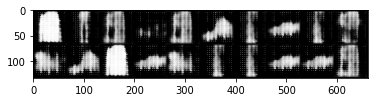

 20%|██        | 2/10 [02:27<09:51, 73.88s/it]

Epoch: [2/10], G_Loss: [ 1.1136], D_Loss: [ 0.5074], time: [147.81567335128784]


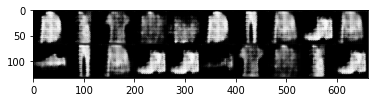

 30%|███       | 3/10 [03:41<08:35, 73.69s/it]

Epoch: [3/10], G_Loss: [ 1.3643], D_Loss: [ 0.5749], time: [221.27884578704834]


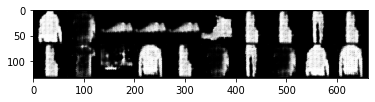

 40%|████      | 4/10 [04:54<07:20, 73.49s/it]

Epoch: [4/10], G_Loss: [ 1.1992], D_Loss: [ 0.6567], time: [294.46215438842773]


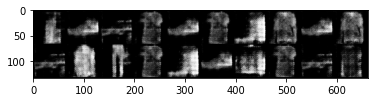

 50%|█████     | 5/10 [06:07<06:06, 73.38s/it]

Epoch: [5/10], G_Loss: [ 1.2003], D_Loss: [ 0.5546], time: [367.6500174999237]


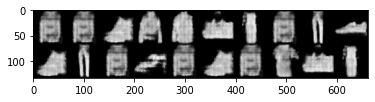

 60%|██████    | 6/10 [07:20<04:53, 73.26s/it]

Epoch: [6/10], G_Loss: [ 2.1172], D_Loss: [ 0.5218], time: [440.6699833869934]


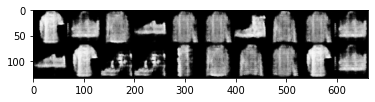

 70%|███████   | 7/10 [08:33<03:39, 73.16s/it]

Epoch: [7/10], G_Loss: [ 1.8085], D_Loss: [ 0.4084], time: [513.6335115432739]


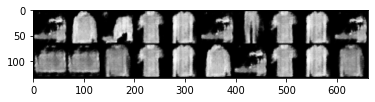

 80%|████████  | 8/10 [09:46<02:26, 73.07s/it]

Epoch: [8/10], G_Loss: [ 1.5515], D_Loss: [ 0.3546], time: [586.5041632652283]


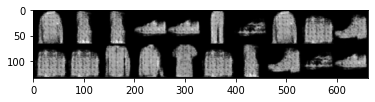

 90%|█████████ | 9/10 [10:59<01:13, 73.03s/it]

Epoch: [9/10], G_Loss: [ 1.8950], D_Loss: [ 0.4135], time: [659.4466342926025]


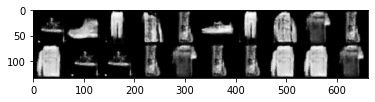

100%|██████████| 10/10 [12:12<00:00, 73.03s/it]

Epoch: [10/10], G_Loss: [ 2.2523], D_Loss: [ 0.3426], time: [732.4899196624756]


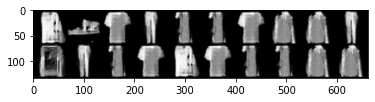

100%|██████████| 10/10 [12:12<00:00, 73.26s/it]


In [6]:
if __name__ == '__main__':
    # set up generator and discriminator and there optimizer
    G = Generator(h_p['z_dim'], h_p['img_channel'], h_p['num_classes'], h_p['img_size'], h_p['embed_size'])
    D = Discriminator(h_p['img_channel'], h_p['num_classes'], h_p['img_size'])
    G.init_weight()
    D.init_weight()
    G = G.to(h_p['device'])
    D = D.to(h_p['device'])
    optim_G = torch.optim.Adam(G.parameters(), lr=h_p['lr'], betas=h_p['betas'])
    optim_D = torch.optim.Adam(D.parameters(), lr=h_p['lr'], betas=h_p['betas'])
    
    G.train()
    D.train()

    model = {
        'G': G,
        'D': D,
        'optim_G': optim_G,
        'optim_D': optim_D,
    }
    GAN_training(model)